<div>
<img src="http://www.sincodiv.org.br/Sincodiv/ImagensGravadas/20201004201918.jpg" width="500"/>
</div>

## Construção de modelo preditivo para inadimplência

In [378]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from scipy.stats import ks_2samp

## Vamos começar analisando a base de parcelas

In [379]:
df_parcelas = pd.read_csv('Dados_Tabela_Parcelas.csv', sep=';', encoding='iso-8859-1')
df_parcelas.head()

,Obra,Bloco,Unidade,Id_Contrato_Vencimento,Contrato,DataVencimento,ValorPrestacao,Principal,JurosTP,Variacoes,Seguros,Descontos,Multa,JurosMora,ProRataIndice,ProRataContrato,ValorPresente,IndiceReajuste,SituacaoParcela,BoletoJM,VencimentoJM,Periodicidade,TipoContrato,TipoEmprestimo,TipoBloqueio,CRM_ProcessamentoPendente,CRM_Operacao,CRM_ParcelaId,CreatedOn,ModifiedOn,GeradoPor,IDRENEG,DataRenegociacao,ValorAbono,ValorAcrescimo,VLRABONOMULTA,VLRABONOJUROS,VLRABONOPRORATA,TX_JUROS,TX_ENCARGOS,MotivoRenegociacao
0,8427,5,00308E,100000001120120000000,1000000011201,2012-06-12 00:00:00.000,1772.33,1213.00,0.00,559.33,0.0,0.0,35.45,866.43,0.00,7.98,2682.19,INCC2,PA,NaN,NaN,MENSAL,PCV,PCV,20.0,0,I,81303BE1-0C76-E411-8D14-001DD8300004,2014-11-26 18:47:30.517,2015-09-25 02:19:52.623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8427,5,00308E,100000001120120000000,1000000011201,2012-07-12 00:00:00.000,1772.33,1213.00,0.00,559.33,0.0,0.0,35.45,840.30,0.00,7.90,2655.98,INCC2,PA,NaN,NaN,MENSAL,PCV,PCV,20.0,0,I,83303BE1-0C76-E411-8D14-001DD8300004,2014-11-26 18:47:30.520,2015-09-25 02:19:52.697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8427,5,00308E,100000001120520000000,1000000011205,2012-10-01 00:00:00.000,10.16,0.00,0.00,10.16,0.0,0.0,0.20,4.15,0.00,0.06,14.57,IGPM2,VR,NaN,NaN,UNICA,PCV,PCV,20.0,0,I,88303BE1-0C76-E411-8D14-001DD8300004,2014-11-26 18:47:30.520,2015-07-30 00:42:38.840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8427,5,00308E,100000001121020000000,1000000011210,2013-03-01 00:00:00.000,583.98,377.67,22.02,184.29,0.0,0.0,11.68,213.12,0.01,4.46,813.24,IGPM2,PA,NaN,NaN,UNICA,PCV,PCV,20.0,0,I,8B303BE1-0C76-E411-8D14-001DD8300004,2014-11-26 18:47:30.520,2015-09-25 02:19:52.767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7957,3,111,100000001454720000000,1000000014547,2015-02-01 00:00:00.000,10313.58,7318.36,69.44,2925.78,0.0,0.0,206.27,6.84,0.00,0.00,10532.00,IGPM1,PA,NaN,NaN,MENSAL,PCV,PCV,NaN,0,I,76EEDEF5-B2AA-E411-AE26-001DD8300006,2015-02-02 02:28:49.540,2015-02-03 02:31:39.070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [380]:
df_parcelas.columns

Index(['Obra', 'Bloco', 'Unidade', 'Id_Contrato_Vencimento', 'Contrato',
       'DataVencimento', 'ValorPrestacao', 'Principal', 'JurosTP', 'Variacoes',
       'Seguros', 'Descontos', 'Multa', 'JurosMora', 'ProRataIndice',
       'ProRataContrato', 'ValorPresente', 'IndiceReajuste', 'SituacaoParcela',
       'BoletoJM', 'VencimentoJM', 'Periodicidade', 'TipoContrato',
       'TipoEmprestimo', 'TipoBloqueio', 'CRM_ProcessamentoPendente',
       'CRM_Operacao', 'CRM_ParcelaId', 'CreatedOn', 'ModifiedOn', 'GeradoPor',
       'IDRENEG', 'DataRenegociacao', 'ValorAbono', 'ValorAcrescimo',
       'VLRABONOMULTA', 'VLRABONOJUROS', 'VLRABONOPRORATA', 'TX_JUROS',
       'TX_ENCARGOS', 'MotivoRenegociacao'],
      dtype='object')

In [381]:
len(df_parcelas), len(df_parcelas['Obra'].unique())

(1000, 23)

#### Existem 23 obras únicas na base de parcelas

In [382]:
df_parcelas['SituacaoParcela'].value_counts()

PA            927
VR             45
CM             16
AM             11
Name: SituacaoParcela, dtype: int64

In [383]:
df_parcelas[df_parcelas['SituacaoParcela'].isnull()]

,Obra,Bloco,Unidade,Id_Contrato_Vencimento,Contrato,DataVencimento,ValorPrestacao,Principal,JurosTP,Variacoes,Seguros,Descontos,Multa,JurosMora,ProRataIndice,ProRataContrato,ValorPresente,IndiceReajuste,SituacaoParcela,BoletoJM,VencimentoJM,Periodicidade,TipoContrato,TipoEmprestimo,TipoBloqueio,CRM_ProcessamentoPendente,CRM_Operacao,CRM_ParcelaId,CreatedOn,ModifiedOn,GeradoPor,IDRENEG,DataRenegociacao,ValorAbono,ValorAcrescimo,VLRABONOMULTA,VLRABONOJUROS,VLRABONOPRORATA,TX_JUROS,TX_ENCARGOS,MotivoRenegociacao
18,8874,1,108,100000001833020000000,1000000018330,2010-03-05 00:00:00.000,2067.14,1000.0,0.0,1067.14,0.0,0.0,41.34,5980.52,0.01,46.03,8135.03,INCC1,NaN,NaN,NaN,MENSAL,PCV,RNP,3.0,0,U,4A9AC034-1376-E411-8D14-001DD8300004,2014-11-26 19:58:19.470,2021-05-24 01:06:22.817,NaN,0.0,1900-01-01 00:00:00.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Vamos analisar apenas um indivíduo para ter maior clareza de algumas variáveis

In [414]:
#100000004902920000000
#100000001586420000000
#100000002432120000000

df_um_contrato = df_parcelas[df_parcelas['Id_Contrato_Vencimento'] == '100000002432120000000']
df_um_contrato.head(10)

,Obra,Bloco,Unidade,Id_Contrato_Vencimento,Contrato,DataVencimento,ValorPrestacao,Principal,JurosTP,Variacoes,Seguros,Descontos,Multa,JurosMora,ProRataIndice,ProRataContrato,ValorPresente,IndiceReajuste,SituacaoParcela,BoletoJM,VencimentoJM,Periodicidade,TipoContrato,TipoEmprestimo,TipoBloqueio,CRM_ProcessamentoPendente,CRM_Operacao,CRM_ParcelaId,CreatedOn,ModifiedOn,GeradoPor,IDRENEG,DataRenegociacao,ValorAbono,ValorAcrescimo,VLRABONOMULTA,VLRABONOJUROS,VLRABONOPRORATA,TX_JUROS,TX_ENCARGOS,MotivoRenegociacao
60,9035,1,57,100000002432120000000,1000000024321,2014-04-30,19.19,1238.06,613.32,-1832.19,0.0,0.0,0.38,1.40,0.0,0.0,20.97,IGPM1,CM,NaN,NaN,MENSAL,PCV,PCV,20.0,0,I,526A50B2-5E75-E411-B2D5-001DD8300006,2014-11-24 17:57:25.533,2014-11-28 13:08:18.527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,9035,1,57,100000002432120000000,1000000024321,2014-12-30,2518.85,1335.22,516.16,667.47,0.0,0.0,50.38,0.84,0.0,0.0,2570.91,IGPM1,PA,NaN,NaN,MENSAL,PCV,PCV,NaN,0,I,6778B203-C390-E411-B2D5-001DD8300006,2014-12-31 02:47:53.367,2014-12-31 02:47:53.367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,9035,1,57,100000002432120000000,1000000024321,2015-01-30,2561.51,1347.89,503.49,710.13,0.0,0.0,51.23,0.85,0.0,0.0,2614.13,IGPM1,PA,NaN,NaN,MENSAL,PCV,PCV,NaN,0,I,9F8440E0-1DA9-E411-8D14-001DD8300004,2015-01-31 02:41:30.717,2015-01-31 02:41:30.717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,9035,1,57,100000002432120000000,1000000024321,2015-02-28,2568.17,1360.68,490.70,716.79,0.0,0.0,51.36,2.56,0.0,0.0,2622.09,IGPM1,PA,NaN,NaN,MENSAL,PCV,PCV,NaN,0,I,9141DB5F-F3BF-E411-AE26-001DD8300006,2015-03-01 03:01:30.117,2015-03-03 03:07:07.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,9035,1,57,100000002432120000000,1000000024321,2015-03-30,2591.32,1373.59,477.79,739.94,0.0,0.0,51.83,0.86,0.0,0.0,2644.25,IGPM1,PA,NaN,NaN,MENSAL,PCV,PCV,NaN,0,I,25F27A36-73D7-E411-93F9-001DD8200000,2015-03-31 02:02:14.290,2015-03-31 02:02:14.290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,9035,1,57,100000002432120000000,1000000024321,2015-04-30,2585.50,1386.62,464.76,734.12,0.0,0.0,51.71,3.43,0.0,0.0,2640.64,IGPM1,PA,NaN,NaN,MENSAL,PCV,PCV,NaN,0,I,696EB4F0-CEEF-E411-93FC-001DD8200000,2015-05-01 02:04:31.627,2015-05-04 02:10:06.620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,9035,1,57,100000002432120000000,1000000024321,2015-05-30,10.78,1399.78,451.60,-1840.60,0.0,0.0,0.22,0.01,0.0,0.0,11.01,IGPM1,CM,NaN,NaN,MENSAL,PCV,PCV,NaN,0,I,918B45EF-6507-E511-93FA-005056200003,2015-05-31 02:30:07.260,2015-06-03 02:16:05.917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,9035,1,57,100000002432120000000,1000000024321,2015-06-30,2665.29,1413.06,438.32,813.91,0.0,0.0,53.31,0.88,0.0,0.0,2719.48,IGPM1,PA,NaN,NaN,MENSAL,PCV,PCV,NaN,0,I,4B224ACD-C71F-E511-93FC-001DD8200000,2015-07-01 02:42:37.027,2015-07-01 02:42:37.027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,9035,1,57,100000002432120000000,1000000024321,2015-07-30,2656.00,1426.47,424.91,804.62,0.0,0.0,53.12,0.88,0.0,0.6,2710.60,IGPM1,PA,NaN,NaN,MENSAL,PCV,PCV,NaN,0,I,C84B9421-5437-E511-93FD-001DD8200000,2015-07-31 02:24:41.880,2015-07-31 02:24:41.880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,9035,1,57,100000002432120000000,1000000024321,2015-08-30,2680.69,1440.01,411.37,829.31,0.0,0.0,53.61,1.78,0.0,0.0,2736.08,IGPM1,PA,NaN,NaN,MENSAL,PCV,PCV,NaN,0,I,F7D30A40-2050-E511-93FD-001DD8200000,2015-08-31 01:54:50.093,2015-09-01 08:00:31.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [385]:
df_um_contrato['SituacaoParcela'].value_counts()

PA            32
CM             4
VR             1
Name: SituacaoParcela, dtype: int64

## Vamos agregar as obras/bloco/unidade por nro parcelas, periodicidade, tipo_contrato, data da ultima parcela e valor total pago

In [387]:
df_parcelas['DataVencimento'] =  pd.to_datetime(df_parcelas['DataVencimento'], format='%Y%m%d %H:%M:%S.%f')


dict_empre = {}

for indx, row in df_parcelas.iterrows():
    obra = row['Obra']
    bloco = row['Bloco']
    unidade = row['Unidade']
    id_ = str(obra) + str(bloco) + str(unidade)
    
    if id_ not in dict_empre:
        dict_empre[id_] = {'Id': id_, 'Obra': obra, 'Bloco': bloco, 'Unidade': unidade}
    
    if 'NroParcelas' not in dict_empre[id_]:
        dict_empre[id_]['NroParcelas'] = int(0)
    else:
        dict_empre[id_]['NroParcelas'] = int(dict_empre[id_]['NroParcelas']) + 1
    if 'Periodicidade' not in dict_empre[id_]:
        dict_empre[id_]['Periodicidade'] = row['Periodicidade']
    if 'TipoContrato' not in dict_empre[id_]:
        dict_empre[id_]['TipoContrato'] = row['TipoContrato']
    if 'DtUltimaParcela' not in dict_empre[id_]:
        dict_empre[id_]['DtUltimaParcela'] = row['DataVencimento']
    elif row['DataVencimento'] > dict_empre[id_]['DtUltimaParcela']:
        dict_empre[id_]['DtUltimaParcela'] = row['DataVencimento']
    if 'ValorTotalPago' not in dict_empre[id_]:
        dict_empre[id_]['ValorTotalPago'] = row['ValorPrestacao']
    else:
        dict_empre[id_]['ValorTotalPago'] = dict_empre[id_]['ValorTotalPago'] + row['ValorPrestacao']

    
df_empreendimentos_parcela = pd.DataFrame(list(dict_empre.values()))
df_empreendimentos_parcela

,Id,Obra,Bloco,Unidade,NroParcelas,Periodicidade,TipoContrato,DtUltimaParcela,ValorTotalPago
0,8427500308E,8427,5,00308E,3,MENSAL,PCV,2013-03-01,4138.80
1,79573111,7957,3,111,1,MENSAL,PCV,2015-03-01,10393.16
2,5988642,5988,6,42,11,ANUAL,PCV,2016-01-01,47321.03
3,88741108,8874,1,108,0,MENSAL,PCV,2010-03-05,2067.14
4,79381133,7938,1,133,14,MENSAL,PCV,2016-02-25,188157.58
5,916811205,9168,1,1205,1,MENSAL,MOD,2010-08-10,12.69
6,8629144,8629,1,44,0,MENSAL,PCV,2012-10-05,1272.16
7,81011111,8101,1,111,1,UNICA,PCV,2013-12-01,66182.38
8,81015310,8101,5,310,2,ANUAL,PCV,2013-11-01,54088.86
9,81015108,8101,5,108,5,MENSAL,PCV,2013-12-01,68071.62


# Agora vamos linkar esses empreendimentos com a base de PosicaoFinanceira para pegar algumas outras informações

In [388]:
df_posicfinan = pd.read_csv('Dados_Tabela_PosicaoFinanceira.csv', sep=';', encoding='iso-8859-1')
df_posicfinan.head()

,Obra,Bloco,Unidade,Empresa,SituacaoUnidade,DataVenda,ValorVenda,DataLiberacaoChaves,FormaPagamento,FaseIncorporacao,DataCessao,DataDesembolso,DataEntregaInicial,DataHabiteSe,StatusDistrato,DataChaves,IndicePreChaves,IndicePosChaves,DebitoAutomatico,SaldoDevedor,DiasAtraso,ValorAtraso,TotalAtraso,CRM_ProcessamentoPendente,CRM_Operacao,CRM_PosicaoFinanceiraId,CreatedOn,ModifiedOn,DataPrevisaoEntrega,ValorPago,ValorPagoAtualizado,TipoPagamento,DataQuitacao,ValorQuitacao,LR_TipoContrato,LR_Saldo,LR_DataVencimento,LR_Codigo,LR_DataRenegociacao,PCVF_SaldoDevedor,PCVF_TotalAtraso,PCVU_SaldoDevedor,PCVU_TotalAtraso,PCVP_SaldoDevedor,PCVP_TotalAtraso,DEC_SaldoDevedor,DEC_TotalAtraso,MOD_SaldoDevedor,MOD_TotalAtraso,LIG_SaldoDevedor,LIG_TotalAtraso,TCS_SaldoDevedor,TCS_TotalAtraso,LOT_SaldoDevedor,LOT_TotalAtraso,CRM_ProcessamentoPendenteRepasse,ValorTotalReceberObras,ValorParcelaChaves,ValorTotalPosObra,DataUltimaPrestacaoPaga,DataUltimaAlteracao
0,6,3,32,3,Q,2012-09-01 00:00:00.000,1097044.00,NaN,2,0,NaN,2012-09-21 00:00:00.000,1999-05-01 00:00:00.000,NaN,NaN,2012-09-01 00:00:00.000,IGPM1,IGPM1,NaN,0.0,0,0.0,0.0,0,U,50AC8160-C56E-E411-B2D5-001DD8300006,2014-11-24 17:40:00.213,2016-06-01 02:30:00.770,1999-05-01 00:00:00.000,-1113495.78,-1414876.57,REP,2013-02-06 00:00:00.000,300000.00,REP,0.0,2013-01-02 00:00:00.000,1.000000e+12,2012-11-28 00:00:00.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN
1,6,3,241,3,Q,2012-04-01 00:00:00.000,1167811.31,NaN,2,0,NaN,2012-04-13 00:00:00.000,1999-05-01 00:00:00.000,NaN,NaN,2012-04-01 00:00:00.000,IGPM1,IGPM1,NaN,0.0,0,0.0,0.0,0,U,41C15F7E-C56E-E411-B2D5-001DD8300006,2014-11-24 17:40:00.220,2016-06-01 02:30:00.780,1999-05-01 00:00:00.000,-1178765.34,-1578280.33,REP,2012-05-30 00:00:00.000,1111754.14,REP,0.0,2012-06-25 00:00:00.000,1.000000e+12,2012-05-07 00:00:00.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN
2,12,1,84,41,Q,2006-03-01 00:00:00.000,46500.01,NaN,3,0,NaN,2009-09-30 00:00:00.000,2000-01-01 00:00:00.000,1994-07-13 00:00:00.000,NaN,2006-03-01 00:00:00.000,IGPM1,IGPM1,NaN,0.0,0,0.0,0.0,1,U,BE2BF803-EFA4-E511-93FF-001DD8200008,2014-11-24 17:40:10.457,2021-05-24 01:00:24.927,2000-01-01 00:00:00.000,0.00,0.00,PCV,NaN,0.00,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,2012-04-25 00:00:00.000,2012-04-25 00:00:00.000
3,12,2,44,41,Q,2009-09-01 00:00:00.000,42833.43,NaN,3,0,NaN,2009-09-30 00:00:00.000,2000-01-01 00:00:00.000,1996-07-25 00:00:00.000,NaN,1995-03-30 00:00:00.000,INCC1,IGPM1,NaN,0.0,0,0.0,0.0,0,U,80AB8160-C56E-E411-B2D5-001DD8300006,2014-11-24 17:40:10.463,2016-05-17 02:30:09.520,2000-01-01 00:00:00.000,-59878.63,-94657.10,PCV,2009-09-30 00:00:00.000,59878.63,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN
4,12,2,64,41,Q,2009-09-01 00:00:00.000,63720.06,NaN,3,0,NaN,2009-09-30 00:00:00.000,2000-01-01 00:00:00.000,1996-07-25 00:00:00.000,NaN,1997-02-28 00:00:00.000,INCC1,IGPM1,NaN,0.0,0,0.0,0.0,0,U,41A126AE-C56E-E411-B2D5-001DD8300006,2014-11-24 17:40:10.470,2016-05-17 02:30:09.530,2000-01-01 00:00:00.000,-70624.11,-111643.71,PCV,2009-09-30 00:00:00.000,70624.11,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN


In [389]:
df_posicfinan.columns

Index(['Obra', 'Bloco', 'Unidade', 'Empresa', 'SituacaoUnidade', 'DataVenda',
       'ValorVenda', 'DataLiberacaoChaves', 'FormaPagamento',
       'FaseIncorporacao', 'DataCessao', 'DataDesembolso',
       'DataEntregaInicial', 'DataHabiteSe', 'StatusDistrato', 'DataChaves',
       'IndicePreChaves', 'IndicePosChaves', 'DebitoAutomatico',
       'SaldoDevedor', 'DiasAtraso', 'ValorAtraso', 'TotalAtraso',
       'CRM_ProcessamentoPendente', 'CRM_Operacao', 'CRM_PosicaoFinanceiraId',
       'CreatedOn', 'ModifiedOn', 'DataPrevisaoEntrega', 'ValorPago',
       'ValorPagoAtualizado', 'TipoPagamento', 'DataQuitacao', 'ValorQuitacao',
       'LR_TipoContrato', 'LR_Saldo', 'LR_DataVencimento', 'LR_Codigo',
       'LR_DataRenegociacao', 'PCVF_SaldoDevedor', 'PCVF_TotalAtraso',
       'PCVU_SaldoDevedor', 'PCVU_TotalAtraso', 'PCVP_SaldoDevedor',
       'PCVP_TotalAtraso', 'DEC_SaldoDevedor', 'DEC_TotalAtraso',
       'MOD_SaldoDevedor', 'MOD_TotalAtraso', 'LIG_SaldoDevedor',
       'LIG_TotalAt

In [390]:
df_posicfinan['DataUltimaPrestacaoPaga'].value_counts()

2012-03-20 00:00:00.000    1
2017-09-28 00:00:00.000    1
2018-09-27 00:00:00.000    1
2012-04-25 00:00:00.000    1
2020-02-01 00:00:00.000    1
2018-08-31 00:00:00.000    1
2019-02-01 00:00:00.000    1
2015-07-06 00:00:00.000    1
2017-08-03 00:00:00.000    1
2017-03-29 00:00:00.000    1
2016-08-26 00:00:00.000    1
2017-07-04 00:00:00.000    1
2019-01-24 00:00:00.000    1
2019-03-13 00:00:00.000    1
2019-08-16 00:00:00.000    1
2017-10-26 00:00:00.000    1
2011-11-25 00:00:00.000    1
2010-07-01 00:00:00.000    1
2017-02-23 00:00:00.000    1
Name: DataUltimaPrestacaoPaga, dtype: int64

### Apesar de ter poucos registros contento valor de ultima prestacao paga, utilizaremos ele para verificar inadimplencia

## Como feito na base de anterior, vamos agrupar por obra/bloco/unidade

In [391]:
df_posicfinan['DataUltimaPrestacaoPaga'] =  pd.to_datetime(df_posicfinan['DataUltimaPrestacaoPaga'], format='%Y%m%d %H:%M:%S.%f')


dict_empre = {}

for indx, row in df_posicfinan.iterrows():
    obra = row['Obra']
    bloco = row['Bloco']
    unidade = row['Unidade']
    id_ = str(obra) + str(bloco) + str(unidade)
    
    if id_ not in dict_empre:
        dict_empre[id_] = {'Id': id_, 'Obra': obra, 'Bloco': bloco, 'Unidade': unidade}
    
    if 'SituacaoUnidade' not in dict_empre[id_]:
        dict_empre[id_]['SituacaoUnidade'] = row['SituacaoUnidade']
    if 'FormaPagamento' not in dict_empre[id_]:
        dict_empre[id_]['FormaPagamento'] = row['FormaPagamento']
    if 'StatusDistrato' not in dict_empre[id_]:
        dict_empre[id_]['StatusDistrato'] = row['StatusDistrato']
    if 'IndicePreChaves' not in dict_empre[id_]:
        dict_empre[id_]['IndicePreChaves'] = row['IndicePreChaves']
    if 'IndicePosChaves' not in dict_empre[id_]:
        dict_empre[id_]['IndicePosChaves'] = row['IndicePosChaves']
    if 'TipoPagamento' not in dict_empre[id_]:
        dict_empre[id_]['TipoPagamento'] = row['TipoPagamento']
    if 'DataUltimaPrestacaoPaga' not in dict_empre[id_] and str(row['DataUltimaPrestacaoPaga']) != 'NaT':
        dict_empre[id_]['DataUltimaPrestacaoPaga'] = row['DataUltimaPrestacaoPaga']
    
df_empreendimentos_posicfinan = pd.DataFrame(list(dict_empre.values()))
df_empreendimentos_posicfinan

,Id,Obra,Bloco,Unidade,SituacaoUnidade,FormaPagamento,StatusDistrato,IndicePreChaves,IndicePosChaves,TipoPagamento,DataUltimaPrestacaoPaga
0,6332,6,3,32,Q,2,NaN,IGPM1,IGPM1,REP,NaT
1,63241,6,3,241,Q,2,NaN,IGPM1,IGPM1,REP,NaT
2,12184,12,1,84,Q,3,NaN,IGPM1,IGPM1,PCV,2012-04-25
3,12244,12,2,44,Q,3,NaN,INCC1,IGPM1,PCV,NaT
4,12264,12,2,64,Q,3,NaN,INCC1,IGPM1,PCV,NaT
...,...,...,...,...,...,...,...,...,...,...,...
995,17771161,177,71,161,Q,0,NaN,INCC1,IGPM1,NaN,NaT
996,17771173,177,71,173,Q,0,NaN,INCC1,IGPM1,NaN,NaT
997,17771174,177,71,174,Q,0,NaN,IGPM1,IGPM1,NaN,NaT
998,17771175,177,71,175,Q,0,NaN,IGPM1,IGPM1,NaN,NaT


### As bases não tem obras em comum.... portanto, vamos mocar os dados para continuar o trabalho..

In [392]:
import random

list_mock = df_empreendimentos_parcela['Id'].unique()

def random_mock(obra):
    return random.choice(list_mock)
    
df_empreendimentos_posicfinan['Id'] = df_empreendimentos_posicfinan['Id'].apply(random_mock)

In [393]:
df_empreendimentos_posicfinan

,Id,Obra,Bloco,Unidade,SituacaoUnidade,FormaPagamento,StatusDistrato,IndicePreChaves,IndicePosChaves,TipoPagamento,DataUltimaPrestacaoPaga
0,5988642,6,3,32,Q,2,NaN,IGPM1,IGPM1,REP,NaT
1,82421241,6,3,241,Q,2,NaN,IGPM1,IGPM1,REP,NaT
2,9035158,12,1,84,Q,3,NaN,IGPM1,IGPM1,PCV,2012-04-25
3,81015402,12,2,44,Q,3,NaN,INCC1,IGPM1,PCV,NaT
4,828313,12,2,64,Q,3,NaN,INCC1,IGPM1,PCV,NaT
...,...,...,...,...,...,...,...,...,...,...,...
995,913351502,177,71,161,Q,0,NaN,INCC1,IGPM1,NaN,NaT
996,91451506,177,71,173,Q,0,NaN,INCC1,IGPM1,NaN,NaT
997,81015402,177,71,174,Q,0,NaN,IGPM1,IGPM1,NaN,NaT
998,82421184,177,71,175,Q,0,NaN,IGPM1,IGPM1,NaN,NaT


In [394]:
result = df_empreendimentos_parcela.merge(df_empreendimentos_posicfinan, left_on='Id', right_on='Id')
result.head()

,Id,Obra_x,Bloco_x,Unidade_x,NroParcelas,Periodicidade,TipoContrato,DtUltimaParcela,ValorTotalPago,Obra_y,Bloco_y,Unidade_y,SituacaoUnidade,FormaPagamento,StatusDistrato,IndicePreChaves,IndicePosChaves,TipoPagamento,DataUltimaPrestacaoPaga
0,8427500308E,8427,5,00308E,3,MENSAL,PCV,2013-03-01,4138.8,95,1,22,Q,3,NaN,INCC1,IGPM1,PCV,NaT
1,8427500308E,8427,5,00308E,3,MENSAL,PCV,2013-03-01,4138.8,153,1,00508A,Q,0,NaN,INCC1,INCC1,NaN,NaT
2,8427500308E,8427,5,00308E,3,MENSAL,PCV,2013-03-01,4138.8,153,2,00901B,Q,2,1.0,IGPM1,IGPM1,NaN,NaT
3,8427500308E,8427,5,00308E,3,MENSAL,PCV,2013-03-01,4138.8,153,4,00302D,Q,2,1.0,IGPM1,IGPM1,NaN,NaT
4,8427500308E,8427,5,00308E,3,MENSAL,PCV,2013-03-01,4138.8,153,4,00802D,Q,0,NaN,INCC1,IGPM1,NaN,NaT


In [395]:
result = result.drop(['Id', 'Obra_x', 'Bloco_x', 'Unidade_x', 'Obra_y', 'Bloco_y', 'Unidade_y'], axis=1)
result.head()

,NroParcelas,Periodicidade,TipoContrato,DtUltimaParcela,ValorTotalPago,SituacaoUnidade,FormaPagamento,StatusDistrato,IndicePreChaves,IndicePosChaves,TipoPagamento,DataUltimaPrestacaoPaga
0,3,MENSAL,PCV,2013-03-01,4138.8,Q,3,NaN,INCC1,IGPM1,PCV,NaT
1,3,MENSAL,PCV,2013-03-01,4138.8,Q,0,NaN,INCC1,INCC1,NaN,NaT
2,3,MENSAL,PCV,2013-03-01,4138.8,Q,2,1.0,IGPM1,IGPM1,NaN,NaT
3,3,MENSAL,PCV,2013-03-01,4138.8,Q,2,1.0,IGPM1,IGPM1,NaN,NaT
4,3,MENSAL,PCV,2013-03-01,4138.8,Q,0,NaN,INCC1,IGPM1,NaN,NaT


In [396]:
print(len(df_empreendimentos_parcela), len(df_empreendimentos_posicfinan), len(result))

47 1000 1000


In [397]:
def is_late(dt_ultima_parc, dt_venc):
    diff = (dt_venc - dt_ultima_parc).days
    
    return diff < 0

result['inadimplencia'] = result.apply(lambda row: is_late(row['DataUltimaPrestacaoPaga'], row['DtUltimaParcela']), axis=1)
result.head()

,NroParcelas,Periodicidade,TipoContrato,DtUltimaParcela,ValorTotalPago,SituacaoUnidade,FormaPagamento,StatusDistrato,IndicePreChaves,IndicePosChaves,TipoPagamento,DataUltimaPrestacaoPaga,inadimplencia
0,3,MENSAL,PCV,2013-03-01,4138.8,Q,3,NaN,INCC1,IGPM1,PCV,NaT,False
1,3,MENSAL,PCV,2013-03-01,4138.8,Q,0,NaN,INCC1,INCC1,NaN,NaT,False
2,3,MENSAL,PCV,2013-03-01,4138.8,Q,2,1.0,IGPM1,IGPM1,NaN,NaT,False
3,3,MENSAL,PCV,2013-03-01,4138.8,Q,2,1.0,IGPM1,IGPM1,NaN,NaT,False
4,3,MENSAL,PCV,2013-03-01,4138.8,Q,0,NaN,INCC1,IGPM1,NaN,NaT,False


In [398]:
result['inadimplencia'].value_counts()

False    986
True      14
Name: inadimplencia, dtype: int64

# Agora vamos gerar o modelo preditivo

## Agora, vamos transformar algumas variáveis.

### Utilizando apenas o mês da última parcela

In [399]:
model_df = result
model_df['MesUltimaParcela'] = result['DtUltimaParcela'].apply(lambda x: x.month)
model_df = model_df.drop(['DtUltimaParcela'], axis=1)

model_df.head()

,NroParcelas,Periodicidade,TipoContrato,ValorTotalPago,SituacaoUnidade,FormaPagamento,StatusDistrato,IndicePreChaves,IndicePosChaves,TipoPagamento,DataUltimaPrestacaoPaga,inadimplencia,MesUltimaParcela
0,3,MENSAL,PCV,4138.8,Q,3,NaN,INCC1,IGPM1,PCV,NaT,False,3
1,3,MENSAL,PCV,4138.8,Q,0,NaN,INCC1,INCC1,NaN,NaT,False,3
2,3,MENSAL,PCV,4138.8,Q,2,1.0,IGPM1,IGPM1,NaN,NaT,False,3
3,3,MENSAL,PCV,4138.8,Q,2,1.0,IGPM1,IGPM1,NaN,NaT,False,3
4,3,MENSAL,PCV,4138.8,Q,0,NaN,INCC1,IGPM1,NaN,NaT,False,3


### Vamos discretizar o valor pago em três faixas

In [400]:
model_df['FaixaPagamento'] = pd.qcut(model_df['ValorTotalPago'], 3, labels=["baixo", "medio", "alto"])
model_df = model_df.drop(['ValorTotalPago'], axis=1)

model_df.head()

,NroParcelas,Periodicidade,TipoContrato,SituacaoUnidade,FormaPagamento,StatusDistrato,IndicePreChaves,IndicePosChaves,TipoPagamento,DataUltimaPrestacaoPaga,inadimplencia,MesUltimaParcela,FaixaPagamento
0,3,MENSAL,PCV,Q,3,NaN,INCC1,IGPM1,PCV,NaT,False,3,baixo
1,3,MENSAL,PCV,Q,0,NaN,INCC1,INCC1,NaN,NaT,False,3,baixo
2,3,MENSAL,PCV,Q,2,1.0,IGPM1,IGPM1,NaN,NaT,False,3,baixo
3,3,MENSAL,PCV,Q,2,1.0,IGPM1,IGPM1,NaN,NaT,False,3,baixo
4,3,MENSAL,PCV,Q,0,NaN,INCC1,IGPM1,NaN,NaT,False,3,baixo


### Vamos discretizar o valor pago em três faixas

In [401]:
model_df['FaixaParcelas'] = pd.qcut(model_df['NroParcelas'], 3, labels=["baixo", "medio", "alto"])
model_df = model_df.drop(['NroParcelas'], axis=1)

model_df.head()

,Periodicidade,TipoContrato,SituacaoUnidade,FormaPagamento,StatusDistrato,IndicePreChaves,IndicePosChaves,TipoPagamento,DataUltimaPrestacaoPaga,inadimplencia,MesUltimaParcela,FaixaPagamento,FaixaParcelas
0,MENSAL,PCV,Q,3,NaN,INCC1,IGPM1,PCV,NaT,False,3,baixo,medio
1,MENSAL,PCV,Q,0,NaN,INCC1,INCC1,NaN,NaT,False,3,baixo,medio
2,MENSAL,PCV,Q,2,1.0,IGPM1,IGPM1,NaN,NaT,False,3,baixo,medio
3,MENSAL,PCV,Q,2,1.0,IGPM1,IGPM1,NaN,NaT,False,3,baixo,medio
4,MENSAL,PCV,Q,0,NaN,INCC1,IGPM1,NaN,NaT,False,3,baixo,medio


In [402]:
from sklearn.preprocessing import LabelEncoder 

nonnumeric_columns = ['SituacaoUnidade', 'Periodicidade', 'TipoContrato', 'FaixaPagamento', 'FaixaParcelas', 'StatusDistrato', 'IndicePreChaves', 'IndicePosChaves', 'TipoPagamento']
le = LabelEncoder()
for feature in nonnumeric_columns:
    model_df[feature] = le.fit_transform(model_df[feature].astype(str))

model_df.head()

,Periodicidade,TipoContrato,SituacaoUnidade,FormaPagamento,StatusDistrato,IndicePreChaves,IndicePosChaves,TipoPagamento,DataUltimaPrestacaoPaga,inadimplencia,MesUltimaParcela,FaixaPagamento,FaixaParcelas
0,1,1,0,3,1,2,0,1,NaT,False,3,1,2
1,1,1,0,0,1,2,2,3,NaT,False,3,1,2
2,1,1,0,2,0,0,0,3,NaT,False,3,1,2
3,1,1,0,2,0,0,0,3,NaT,False,3,1,2
4,1,1,0,0,1,2,0,3,NaT,False,3,1,2


In [403]:
model_df['inadimplencia'] = model_df['inadimplencia'].astype(int)

In [404]:
model_df = model_df.drop(['DataUltimaPrestacaoPaga', 'DataUltimaPrestacaoPaga', 'StatusDistrato'], axis=1)
model_df.head()

,Periodicidade,TipoContrato,SituacaoUnidade,FormaPagamento,IndicePreChaves,IndicePosChaves,TipoPagamento,inadimplencia,MesUltimaParcela,FaixaPagamento,FaixaParcelas
0,1,1,0,3,2,0,1,0,3,1,2
1,1,1,0,0,2,2,3,0,3,1,2
2,1,1,0,2,0,0,3,0,3,1,2
3,1,1,0,2,0,0,3,0,3,1,2
4,1,1,0,0,2,0,3,0,3,1,2


## Correlação entre as features

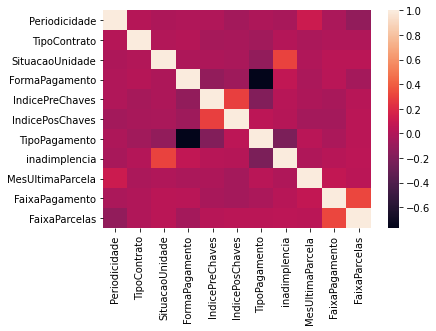

In [405]:
corr = model_df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Nota-se que FormaPagamento e TipoPagamento são features fortemente correlacionadas. Podemos dropar uma delas.

In [406]:
model_df = model_df.drop(['TipoPagamento'], axis=1)

# Por fim, vamos criar o modelo

In [407]:
X = model_df.drop(['inadimplencia'], axis=1)
y = model_df['inadimplencia']

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [409]:
regr = linear_model.Lars()
regr.fit(X_train, y_train)

gbm = xgb.XGBClassifier().fit(X_train, y_train)

y_pred_reg = regr.predict(X_test)
y_pred_gbm = gbm.predict(X_test)

In [410]:
feature_importance = gbm.get_booster().get_score(importance_type="gain")
feature_importance

{'FaixaPagamento': 0.5658411916666666,
 'FaixaParcelas': 0.42278921768888894,
 'FormaPagamento': 1.1775057501151078,
 'IndicePreChaves': 0.4449941708135593,
 'MesUltimaParcela': 0.5182467204451612,
 'Periodicidade': 0.732950211}

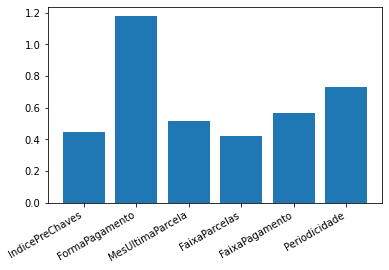

In [411]:
fig, ax = pyplot.subplots()
ax.bar(feature_importance.keys(), feature_importance.values())

fig.autofmt_xdate()
pyplot.show()

In [412]:
# The mean squared error
print('Acurácia - Modelo XGBOOST: %.2f' % accuracy_score(y_test, y_pred_gbm))

Acurácia - Modelo XGBOOST: 0.98


In [413]:
def ks_stat(y, yhat):
    return ks_2samp(yhat[y==1], yhat[y!=1]).statistic
print('KS - Modelo de regressão: %.2f' % ks_stat(y_test, y_pred_reg))

KS - Modelo de regressão: 0.60
